In [1]:
### If save data:
save_data = False

if save_data:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/

In [2]:
import jax
from jax.config import config
import requests
import os

print(jax.devices())

[GpuDevice(id=0)]


In [3]:
!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim

import jax.numpy as np
from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import matplotlib.pyplot as plt
import numpy as npo
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import sys

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

# t_start = datetime.now(pytz.timezone('US/Eastern'))
# t_end = datetime.now(pytz.timezone('US/Eastern'))
# print('Time Elapsed: ' + time_diff(t_start,t_end))

# Dataset Preperation

/usr/local/lib/python3.6/dist-packages/jax/_src/random.py:478: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation
  warnings.warn(msg, FutureWarning)


(1000, 10)
(60000, 28, 28)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


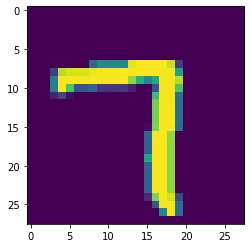

In [7]:
# class to download and maintain datasets
class DataSet():
  def __init__(self, name, subset_size, batch_size, test_size, key):
    
    self.name = name
    self.subset_size = subset_size 
    self.num_classes = 10
    if name == 'CIFAR10':
      self.total_size = 50000
      self.dim = 1024
    elif name == 'CIFAR100':
      self.total_size = 50000
      self.dim = 1024
      self.num_classes = 100
    else:
      self.total_size = 60000
      self.dim = 784

    self.batch_size = batch_size
    self.key = key
    self.subset_inds = random.shuffle(key, np.arange(self.total_size) )[0:subset_size]
    self.test_size = test_size
    self.all_data = npo.zeros((self.total_size, self.dim))
    self.all_labels = npo.zeros((self.total_size, self.num_classes))
    self.all_test_data = npo.zeros((self.test_size, self.dim))
    self.all_test_labels = npo.zeros((self.test_size, self.num_classes))
    return


  # processes data into np arrays
  def process_data(self, batch_block):
    image, label = batch_block['image'], batch_block['label']
    samples = image.shape[0]
    if image.shape[3] == 3:
      image = tf.image.rgb_to_grayscale(tf.image.per_image_standardization(image)).numpy()
    #plt.imshow(image[0,:,:,0],cmap='gray')
    #plt.show()
    # image = np.reshape(image, (image.shape[0], self.dim)) / 255
    # image = np.array(image, dtype = np.float32).T# / np.linalg.norm(image, axis = 1)

    image = np.reshape(image, (image.shape[0], self.dim))
    image = image.T - np.mean(image, axis = 1)
    image = image / np.linalg.norm(image, axis = 0) 

    label = np.eye(self.num_classes)[label]
    return {'image': image.T, 'label': label} 

  def download_and_process(self):
    batch_size = self.batch_size
    if self.name =='CIFAR10':
      test_data = tfds.load('cifar10', split=tfds.Split.TEST)
      train_data = tfds.load('cifar10', split=tfds.Split.TRAIN)
    elif self.name == 'CIFAR100':
      test_data = tfds.load('cifar100', split=tfds.Split.TEST)
      train_data = tfds.load('cifar100', split=tfds.Split.TRAIN)
    else:
      test_data = tfds.load('mnist', split=tfds.Split.TEST)
      train_data = tfds.load('mnist', split=tfds.Split.TRAIN)
    train_data_shuff = tfds.as_numpy(train_data.shuffle(1024).batch(batch_size))
    test_data_shuff = tfds.as_numpy(test_data.shuffle(1024).batch(batch_size)) 

    for i,batch in enumerate(train_data_shuff):
      datai = self.process_data(batch)
      self.all_data[i*batch_size:(i+1)*batch_size,:] = datai['image']
      self.all_labels[i*batch_size:(i+1)*batch_size,:] = datai['label']
    
    print(datai['label'].shape)
    for i,batch in enumerate(test_data_shuff):
      datai = self.process_data(batch)
      self.all_test_data[i*batch_size:(i+1)*batch_size,:] = datai['image']
      self.all_test_labels[i*batch_size:(i+1)*batch_size,:] = datai['label']

    return
  
  # gets a subset of the data to train/test on
  def get_subset(self):
    train_sub = self.all_data[self.subset_inds,:]
    labels_sub = self.all_labels[self.subset_inds,:]
    return (train_sub, labels_sub)


def test_dataset_class(dataset_name, img_num):

  key = random.PRNGKey(0)
  test_size = 12000
  subset_size = 12000
  batch_size = 1000
  d_mnist = DataSet(dataset_name, subset_size, batch_size, test_size, key)
  d_mnist.download_and_process()

  x = d_mnist.all_data.reshape(60000,28,28)
  y = d_mnist.all_labels

  print(x.shape)
  print(y[img_num])
  plt.imshow(x[img_num]);

test_dataset_class('MNIST', 600)

# Theory Curves

In [5]:
class Theory():
  def __init__(self, expt):
    self.expt = expt
    self.result = {}
    return

  def get_spectrum_vecs(self, subset_size):

    X = self.expt.dataset.all_data[self.expt.dataset.subset_inds,:]
    y = self.expt.dataset.all_labels[self.expt.dataset.subset_inds,:]
    num_pca = len(self.expt.dataset.subset_inds)
    assert(subset_size == num_pca)
    ## Initialize the kernel
    init_fn, apply_fn, kernel_fn = fully_connected(self.expt.width, self.expt.depth, self.expt.dataset.num_classes)
    ## Calculate the kernel Gram matrix
    K = kernel_fn(X,None,'ntk')
    ker_trace = np.mean(np.trace(K))

    ## Calculate the spectrum
    t_start = datetime.now(pytz.timezone('US/Eastern'))
    spectrum, vecs = np.linalg.eigh(K)
    t_end = datetime.now(pytz.timezone('US/Eastern'))
    print('Time to get eigenvalues: ' + time_diff(t_start,t_end))

    print('Theory Curves - sum spectrum', np.sum(spectrum), 'Kernel_trace', ker_trace)

    inds = np.argsort(spectrum)[::-1]
    spectrum = spectrum[inds]/subset_size
    vecs = vecs[:,inds]
    coeffs = vecs.T @ y

    self.result = {'spectrum': spectrum, 'vecs': vecs, 'coeffs': coeffs}
    return self.result
  
  def theory_learning_curves(self, ptheory):

    num_pca = len(self.expt.dataset.subset_inds)
    noise_std = self.expt.noise_std
    if self.expt.reg == 0:
      lamb = 1e-10
    else:
      lamb = self.expt.reg

    r = self.result
    spectrum = r['spectrum']
    coeffs = r['coeffs']

    ker_trace = np.sum(spectrum)

    w = npo.diag(spectrum**(-0.5)) @ coeffs

    pvals = ptheory

    all_errs = npo.zeros((len(lamb), len(noise_std), len(pvals)))
    train_errs = npo.zeros((len(lamb), len(noise_std), len(pvals)))
    test_errs = npo.zeros((len(lamb), len(noise_std), len(pvals)))
    for i, reg in enumerate(lamb):
      ## Multiply reg with the sum of spectrum
      kappa_vals = ker_sim.solve_kappa(pvals, reg * ker_trace, spectrum)
      gamma_vals= npo.array([ker_sim.gamma_fn(pvals[i], kappa_vals[i], spectrum).sum() for i in range(len(pvals))])

      noiseless = npo.zeros(len(pvals))
      noise_train = npo.zeros(len(pvals))
      weight_sum = npo.sum(w**2, axis = 1) * spectrum
      sample_prefactor = kappa_vals**2 /(1 - gamma_vals)/num_pca 
      for l, p in enumerate(pvals):
        noiseless[l] = sample_prefactor[l] * npo.sum(weight_sum / (p*spectrum + kappa_vals[l])**2)
        noise_train[l] = np.sum(weight_sum / (p*spectrum + kappa_vals[l])**2)

      for j, noise in enumerate(noise_std):
        noise_error = noise**2 * gamma_vals/(1 - gamma_vals) * coeffs.shape[1]
        all_errs[i,j] = noiseless + noise_error
        train_errs[i,j] = reg**2/kappa_vals**2 * (all_errs[i,j] + noise**2)
        test_errs[i,j] = num_pca/(num_pca-pvals)*(all_errs[i,j]-pvals/num_pca*train_errs[i,j])

    return all_errs, train_errs, test_errs

# Experiment Functions

In [10]:
def tot_params(params): 
  from jax.tree_util import tree_flatten
  flat, _ = tree_flatten(params)
  tot_params = 0

  for obj in flat:
    tot_params += np.array(obj).size

  return tot_params

def mean_norm_sq(params1, params2):
  from jax.tree_util import tree_flatten
  flat1, _ = tree_flatten(params1)
  flat2, _ = tree_flatten(params2)
  tot_norm = 0
  for i in range(len(flat1)):
    obj1 = flat1[i]
    obj2 = flat2[i]
    norm = np.vdot(obj1, obj1) + np.vdot(obj2, obj2) - 2*np.vdot(obj1, obj2)
    tot_norm += norm
  return tot_norm

def l2_norm_sq(params):
  from jax.tree_util import tree_flatten
  flat, _ = tree_flatten(params)
  tot_norm = 0
  for i in range(len(flat)):
    obj = flat[i]
    norm = np.vdot(obj, obj)
    tot_norm += norm
  return tot_norm

# Define fully connected architecture
def fully_connected(width, depth, num_classes, weight_std = 1):
    layers = []
    for i in range(depth):
        layers += [stax.Dense(width, W_std = weight_std), stax.Relu()]
    layers += [stax.Dense(num_classes, W_std = weight_std)]
    return stax.serial(*layers)

# NTK regression experiment
def kernel_gen_expt(X, y, reg, noise_std, nvals, kernel_fn, train_params, key):

    num_repeats = train_params['num_repeats']
    keys = random.split(key, num_repeats)

    all_errs = npo.zeros(len(nvals))
    std = npo.zeros(len(nvals))
    all_train = npo.zeros(len(nvals))
    train_std = npo.zeros(len(nvals))
    for i, n in enumerate(nvals):
        print("P = %d" % n)
        errors = npo.zeros(num_repeats)
        train = npo.zeros(num_repeats)
        t_start = datetime.now()
        for j in range(num_repeats):
            shuff_inds = random.shuffle(keys[j,:], np.arange(len(y)))
            inds = shuff_inds[0:n]
            inds_test = shuff_inds[n:len(y)]
            ## Add the noise.
            y_train = y + npo.random.normal(0, noise_std, y.shape)
            ## Perform regression
            predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, X[inds,:], y_train[inds,:], diag_reg=reg)
            yhat = predict_fn(x_test=X, get='ntk', compute_cov=False)
            #ntk_mean = np.reshape(ntk_mean, (-1,))
            yhat = np.array(yhat)
            errors[j] = 1/len(y) * npo.linalg.norm(yhat - y)**2
            train[j] =  1/len(inds) * npo.linalg.norm(yhat[inds,:] - y[inds,:])**2
            sys.stdout.write("\r train: %e | test: %e" %(train[j], errors[j]))
        t_end = datetime.now()
        print(' | Time Elapsed: ' + time_diff(t_start,t_end))

        all_errs[i] = npo.mean(errors)
        std[i] = npo.std(errors)
        all_train[i] = npo.mean(train)
        train_std[i] = npo.std(train)
    return all_errs, std, all_train, train_std

# training NN here
def train_nn(key, init_fn, apply_fn, Xtest, train_set, loss_nn, loss_unreg, grad_nn, lr, num_iter):
  (X, y) = train_set
  opt_init, opt_update, get_params = optimizers.sgd(lr)
  _,params = init_fn(key, (-1, X.shape[1]))
  opt_state = init_state = opt_init(params)

  losses = []
  loss0 = 0

  for t in range(num_iter):
    opt_state = opt_update(t, grad_nn(opt_state, init_state, *train_set), opt_state)
    if t % 10 == 0:
      loss_t = loss_nn(get_params(opt_state), get_params(init_state), *train_set)
      loss_reg_t = loss_unreg(get_params(opt_state), *train_set)
      if t == 0:
        loss0 = loss_t
    losses.append(loss_t)

  yhat_ensemble = apply_fn(get_params(opt_state), Xtest)
  losses = np.array(losses)
  return opt_state, losses, yhat_ensemble


# NN generalization expt 
def nn_expt(X, y, pvals, lamb, noise, init_fn, apply_fn, kernel_fn, width, depth, train_params, spectrum, alpha_t):

    num_repeats = train_params['num_repeats']
    num_iter = train_params['num_iter']
    keys = random.split(key, num_repeats)
    l2_ridge = lamb

    num_pca = y.shape[0]
    num_class = y.shape[1]
    
    all_errs = npo.zeros(len(pvals))
    std = npo.zeros(len(pvals))
    all_train = npo.zeros(len(pvals))
    train_std = npo.zeros(len(pvals)) 
    kernel_movement = npo.zeros(len(pvals))

    K = kernel_fn(X, None, 'ntk')

    for i, p in enumerate(pvals):
        errors = npo.zeros(num_repeats)
        trains = npo.zeros(num_repeats)
        nn_train_loss = npo.zeros((num_repeats, num_iter))
        kernel_move = npo.zeros(num_repeats)

        t_start = datetime.now()
        print('P = %d' %p)
        for j in range(num_repeats):
            shuff_inds = random.shuffle(keys[j,:], np.arange(len(y)))
            inds = shuff_inds[0:p]
            inds_test = shuff_inds[p:len(y)]
            y_noisy = y[inds,:] + npo.random.normal(0, noise, y[inds,:].shape)/np.sqrt(num_class)
            train_set = (X[inds,:], y_noisy)

            Ktr = kernel_fn(X[inds,:], None, 'ntk')
            ker_trace = np.trace(Ktr)
            lamb0 = np.max(np.linalg.eigvalsh(Ktr))

            lr_max = nt.predict.max_learning_rate(Ktr) ## Same as 2 * p / lamb0
            lr = lr_max
            
            outsize = p*num_class

            _,initparams = init_fn(keys[j,:], (-1, X[inds,:].shape[1]))
            opt_init, opt_update, get_params = optimizers.sgd(lr)

            def loss_fn(X,y,params):
              return np.linalg.norm(apply_fn(params, X) - y)**2/(2*p)

            loss_nn = jit(lambda params, params_init, X, y: loss_fn(X,y,params))
            loss_unreg = jit(lambda params, X, y: np.linalg.norm(apply_fn(params, X) - y)**2)
            grad_nn = jit(lambda opt_state, init_state, X, y: grad(loss_nn)(get_params(opt_state), get_params(init_state), X, y))

            #### New Stuff ####
            ensemble_size = 1
            ensemble_key = random.split(keys[j,:], ensemble_size)

            ######################

            opt_state, train_losses, yhat_ensemble = vmap(train_nn, (0, None, None, None, None, None, None, None, None, None))(ensemble_key, init_fn, apply_fn, 
                                                                                                                         X, train_set, loss_nn, loss_unreg, 
                                                                                                                         grad_nn, lr, num_iter)

            mean_train_loss = np.mean(train_losses, axis=0)
            nn_train_loss[j] = mean_train_loss
            
            yhat = np.mean(yhat_ensemble, axis=0)
            yhat_std = np.std(yhat_ensemble, axis=0)

            errors[j] = 1/len(y) * npo.linalg.norm(yhat - y)**2
            trains[j] = 1/len(inds) * npo.linalg.norm(yhat[inds,:] - y_noisy)**2
            sys.stdout.write("\rNN tr error: %0.3e | true tr error: %0.3e | test error: %0.3e" % (mean_train_loss[-1]/mean_train_loss[0], trains[j], errors[j]))

        t_end = datetime.now()
        print(' | Time Elapsed: ' + time_diff(t_start,t_end))
        if p > 9:
          plt.figure(figsize=(5,4))
          plt.loglog(np.mean(nn_train_loss, axis = 0))
          plt.show()

        all_errs[i] = npo.mean(errors)
        std[i] = npo.std(errors)
        all_train[i] = npo.mean(trains)
        train_std[i] = npo.std(trains)
        kernel_movement[i] = npo.mean(kernel_move)
    return all_errs, std, all_train, train_std 


################################################# NEW #########################################3

class Experiment():
  def __init__(self, dataset, pvals, width, depth, reg, noise_std, lr, num_iter, num_repeats):
    self.dataset = dataset
    self.key = dataset.key
    ## Number of training samples (pvals) and FC NN architecture
    self.pvals = pvals
    self.width = width
    self.depth = depth
    ## There are two possible variables for experiments: reg and noise_std
    self.reg = reg
    self.noise_std = noise_std
    ##
    self.train_params = {'lr': lr, 'num_iter': num_iter, 'num_repeats': num_repeats, 'num_pca': dataset.subset_size}
    ##
    self.result = {'gen_errs': [], 'gen_stds': []}
    self.expt_name = ''
    self.trace = 0
    self.spectrum = np.zeros(dataset.subset_size)
    self.alpha_t = np.zeros(dataset.subset_size)
    return
  ## Kernel Training
  def NTK_train(self):
    init_fn, apply_fn, kernel_fn = fully_connected(self.width, self.depth, self.dataset.num_classes)

    all_errs = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))
    all_stds = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))
    all_train = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))
    all_train_stds = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))

    tot_time_start = datetime.now()
    for i, reg in enumerate(self.reg):
      for j, noise in enumerate(self.noise_std):
        print('******** reg: %e, noise: %e ************' % (reg,noise))
        kernel_fn = jit(kernel_fn, static_argnums=(2,))
        errs, stds, train, train_stds = kernel_gen_expt(*self.dataset.get_subset(), reg, noise, self.pvals, kernel_fn, self.train_params, self.key)
        all_errs[i,j,:] = errs
        all_stds[i,j,:] = stds
        all_train[i,j,:] = train
        all_train_stds[i,j,:] = train_stds

    tot_time_end = datetime.now()
    print('Total Time for Kernel Regression with P = %d: ' %np.amax(self.pvals) + time_diff(tot_time_start, tot_time_end))

    self.result['gen_errs'] = all_errs
    self.result['gen_stds'] = all_stds
    self.expt_name = 'NTK'
    return all_errs, all_stds, all_train, all_train_stds
  
  def NN_train(self):

    all_errs = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))
    all_stds = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))
    all_train = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))
    train_stds = npo.zeros((len(self.reg), len(self.noise_std), len(self.pvals)))

    tot_time_start = datetime.now()
    for i, lamb in enumerate(self.reg):
      for j, noise in enumerate(self.noise_std):
        print('******** Reg: %0.2e, Noise: %0.2e ************' %(lamb, noise))
        
        init_fn, apply_fn, kernel_fn = fully_connected(self.width, self.depth, self.dataset.num_classes)
        emp_kernel_fn = nt.empirical_kernel_fn(apply_fn)

        errs, stds, train, train_std = nn_expt(*self.dataset.get_subset(), self.pvals, lamb, noise, 
                                               init_fn, apply_fn, kernel_fn, self.width, self.depth, 
                                               self.train_params, self.spectrum, self.alpha_t)
        
        all_errs[i,j,:] = errs
        all_stds[i,j,:] = stds
        all_train[i,j,:] = train
        train_stds[i,j,:] = train_std

    tot_time_end = datetime.now()
    print('Total Time for NN Training with P = %d: ' %np.amax(self.pvals) + time_diff(tot_time_start, tot_time_end))

    return all_errs, all_stds, all_train, train_stds
  

# Perform Experiments

Experiment Start Time:  01-15_17-53
(500, 10)
Time to get eigenvalues: 0h 0m 0s
Theory Curves - sum spectrum 1.2753177 Kernel_trace 1.2753181


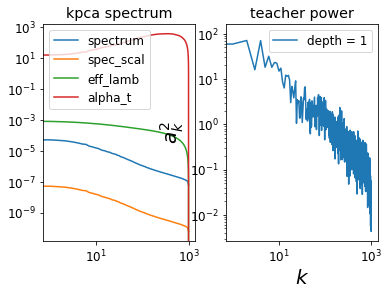

******** reg: 0.000000e+00, noise: 1.000000e-02 ************
P = 10
 train: 8.266121e-04 | test: 8.092395e-01 | Time Elapsed: 0h 0m 0s
P = 29
 train: 9.612122e-04 | test: 6.204486e-01 | Time Elapsed: 0h 0m 0s
P = 89
 train: 1.010567e-03 | test: 4.412142e-01 | Time Elapsed: 0h 0m 0s
P = 266
 train: 9.486761e-04 | test: 2.707802e-01 | Time Elapsed: 0h 0m 0s
P = 794
 train: 9.947600e-04 | test: 5.383262e-02 | Time Elapsed: 0h 0m 0s
Total Time for Kernel Regression with P = 794: 0h 0m 2s


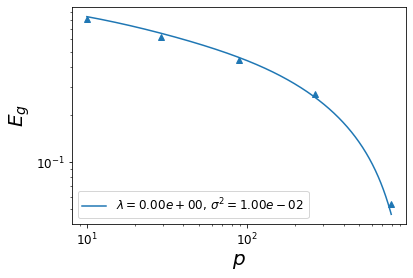

******** Reg: 0.00e+00, Noise: 1.00e-02 ************
P = 10
NN tr error: 1.477e-17 | true tr error: 5.150e-15 | test error: 8.167e-01 | Time Elapsed: 0h 0m 59s


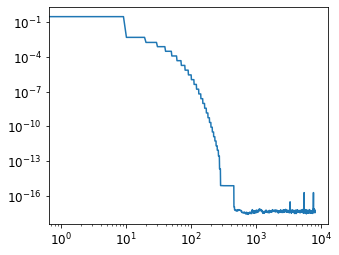

P = 29
NN tr error: 2.332e-16 | true tr error: 7.199e-15 | test error: 6.030e-01 | Time Elapsed: 0h 0m 58s


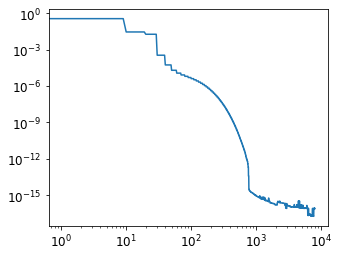

P = 89
NN tr error: 1.717e-15 | true tr error: 9.784e-15 | test error: 3.952e-01 | Time Elapsed: 0h 0m 59s


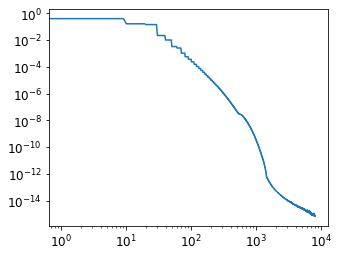

P = 266
NN tr error: 7.394e-09 | true tr error: 6.385e-09 | test error: 2.381e-01 | Time Elapsed: 0h 1m 4s


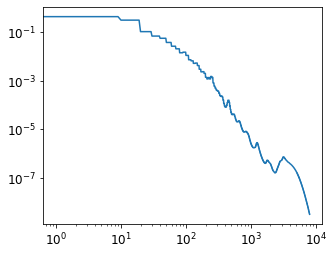

P = 794
NN tr error: 6.890e-07 | true tr error: 5.996e-07 | test error: 5.170e-02 | Time Elapsed: 0h 1m 11s


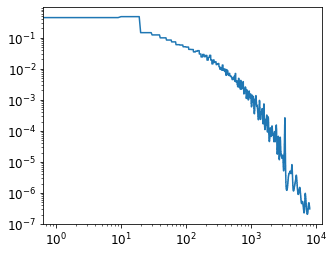

Total Time for NN Training with P = 794: 0h 5m 16s


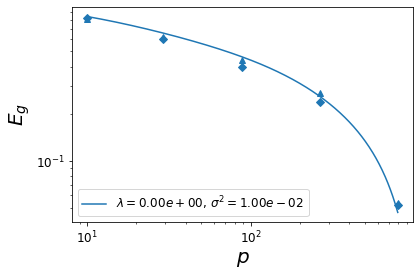

Experiment End Time: 0h 5m 44s


In [11]:
##########################################################
##########################################################

plt.rcParams.update({'font.size': 12})
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

time_exp_start = datetime.now(pytz.timezone('US/Eastern'))
timestamp = time_exp_start.strftime("%m-%d_%H-%M")
print('Experiment Start Time: ', timestamp)

dataset_name ='MNIST'
expt_decorator = dataset_name + '_' + timestamp

##########################################################
##########################################################

key = random.PRNGKey(0)
test_size = 10000
subset_size = 1000
batch_size = 500
d_mnist = DataSet(dataset_name, subset_size, batch_size, test_size, key)
d_mnist.download_and_process()

## Network:
width = 1024
depth = 1
## Variables
reg = [0]
noise_std = [0.01]
## Training prameters
lr = 0.1
num_iter = 8000
num_repeats = 1
## Range of training samples
pvals = npo.logspace(np.log10(10), np.log10(subset_size)-0.1, 5).astype('int')

depth_expt = Experiment(d_mnist, pvals, width, depth, reg, noise_std, lr, num_iter, num_repeats)

params = {'dataset_name': dataset_name,
          'width': width, 'depth': depth,
          'reg': reg, 'noise_std': noise_std,
          'lr': lr, 'num_iter': num_iter, 'num_repeats': num_repeats,
          'test_size': test_size, 'num_pca': subset_size,'batch_size': batch_size}

## Theory Learning Curves ###
ptheory = np.logspace(np.log10(10), np.log10(subset_size)-0.1, 500)
t = Theory(depth_expt)
result = t.get_spectrum_vecs(subset_size) # Get the spectrum

tot_errs, train_errs, test_errs = t.theory_learning_curves(ptheory) # Get the theory learning curves
if save_data:
  filename_Theory = expt_decorator + '_NTK_theory.npz'
  np.savez(filename_Theory, ptheory, result, tot_errs, train_errs, test_errs, params)

spectrum = npo.array(result['spectrum'])
alpha_t = npo.array([npo.sum(spectrum[i:])/spectrum[i] for i in range(len(spectrum))]) - 1
power = npo.sum(result['coeffs']**2, axis = 1)
depth_expt.spectrum = spectrum
depth_expt.alpha_t = alpha_t

#################  Plot Spectrum and Power ##################
fig, [ax0,ax1] = plt.subplots(1, 2)

ax0.loglog(spectrum, label = 'spectrum')
ax0.loglog(spectrum/subset_size, label = 'spec_scal')
ax0.loglog(alpha_t*spectrum, label = 'eff_lamb')
ax0.loglog(alpha_t, label = 'alpha_t')
ax0.legend()
ax0.set_title('kpca spectrum')

ax1.loglog(power, label = 'depth = %d' % depth)
ax1.set_xlabel(r'$k$', fontsize=20)
ax1.set_ylabel(r'$a_k^2$', fontsize=20)
ax1.legend()
ax1.set_title('teacher power')
plt.show()

##########################################################
############ Calculate NTK Regression Curves #############
##########################################################

errs_ker, stds_ker, train_ker, train_std_ker = depth_expt.NTK_train()
if save_data:
  filename_NTK = expt_decorator + '_NTK_errs.npz'
  np.savez(filename_NTK, pvals, errs_ker, stds_ker, train_ker, train_std_ker)

for i, lamb in enumerate(reg):
  for j, noise in enumerate(noise_std):
    plt.plot(ptheory,  tot_errs[i,j] , color = 'C%d' % i, label = r'$\lambda = %0.2e,\,\sigma^2 = %0.2e$' % (lamb,noise))
    plt.errorbar(pvals, errs_ker[i,j,:], stds_ker[i,j,:], fmt='^', color = 'C%d' % i)

plt.xlabel(r'$p$', fontsize=20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

#######################################################
############ Calculate NN Training Curves #############
#######################################################

errs_nn, stds_nn, train_nn, train_std_nn = depth_expt.NN_train()
if save_data:
  filename_NN = expt_decorator + '_NN_errs.npz'
  np.savez(filename_NN, errs_nn, stds_nn, train_nn, train_std_nn)


for i, lamb in enumerate(reg):
  for j, noise in enumerate(noise_std):
    plt.plot(ptheory,  tot_errs[i,j] , color = 'C%d' % i, label = r'$\lambda = %0.2e,\,\sigma^2 = %0.2e$' % (lamb,noise))
    plt.errorbar(pvals, errs_ker[i,j,:], stds_ker[i,j,:], fmt='^', color = 'C%d' % i)
    plt.errorbar(pvals, errs_nn[i,j,:], stds_nn[i,j,:], fmt='D', color = 'C%d' % i)

plt.xlabel(r'$p$', fontsize=20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
if save_data: plt.savefig(expt_decorator + '_learning_curve.pdf')
plt.show()

time_exp_end = datetime.now(pytz.timezone('US/Eastern'))
print('Experiment End Time: ' + time_diff(time_exp_start,time_exp_end))